In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import sys
import pickle 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    
from processing_scripts import model_utils 

# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

In [3]:
# import appeals data
appeals = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/appeals_data_final.csv'))
appeals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242466 entries, 0 to 242465
Data columns (total 44 columns):
idncase                                242466 non-null int64
idnproceeding                          242466 non-null int64
idnAppeal                              242466 non-null float64
nat_grouped                            242466 non-null object
lang_grouped                           242466 non-null object
ij_code_grouped                        242466 non-null object
Male_judge                             226481 non-null float64
Year_Appointed_SLR                     226481 non-null float64
Year_College_SLR                       226481 non-null float64
Year_Law_school_SLR                    226481 non-null float64
Government_Years_SLR                   226481 non-null float64
Govt_nonINS_SLR                        226481 non-null float64
INS_Years_SLR                          226481 non-null float64
Military_Years_SLR                     226481 non-null float64
NGO_Years_SLR 

# Exploratory Data Analysis  

Correlate appeal grant rate with various features 

In [47]:
def plot_feature(df, feature_list, feature_name, 
                 min_samples=None, limit_range=None, limit_values=None, limit_top_n=None, sort_by='index'): 
    """ Plots the average grant rate and number of appeals by feature / list of features """
    x = df.groupby(feature_list)['granted'].agg(['size', np.mean])
    if limit_range is not None: 
        x = x[(x.index >= limit_range[0]) & (x.index <= limit_range[1])]
    if limit_values is not None: 
        x = x[x.index.isin(limit_values)]
    if limit_top_n is not None: 
        x = x.sort_values(by='size', ascending=False)[:limit_top_n]
    if min_samples is not None: 
        x = x[x['size'] >= min_samples] 
    if sort_by == 'index': 
        x = x.sort_index(ascending=True)
    elif sort_by == 'size':
        x = x.sort_values(by='size', ascending=False)
    elif sort_by == 'mean-high-low':
        x = x.sort_values(by='mean', ascending=False)
    elif sort_by == 'mean-low-high':
        x = x.sort_values(by='mean', ascending=True)
    else: 
        raise Exception("Invalid sort_by argument (valid options include: 'index', 'size, 'mean-high-low', 'mean-low-high'!")
    xn = range(len(x))
    fig, ax1 = plt.subplots(figsize=(16, 5))
    ax2 = ax1.twinx()  # set up the 2nd axis
    ax1.plot(xn, x['mean'], label='Avg Grant Rate') #plot the Revenue on axis #1
    ax2.bar(xn, x['size'], alpha=0.2, color='gray', label='Number of Appeals')
    ax2.grid(b=False)
    ax1.set_title('Average Grant Rate and Number of Appeals by {}'.format(feature_name))
    ax1.set_ylabel('Appeal Grant Rate')
    ax2.set_ylabel('Number of Appeals')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')    
    plt.xticks(xn, x.index)
    return x 

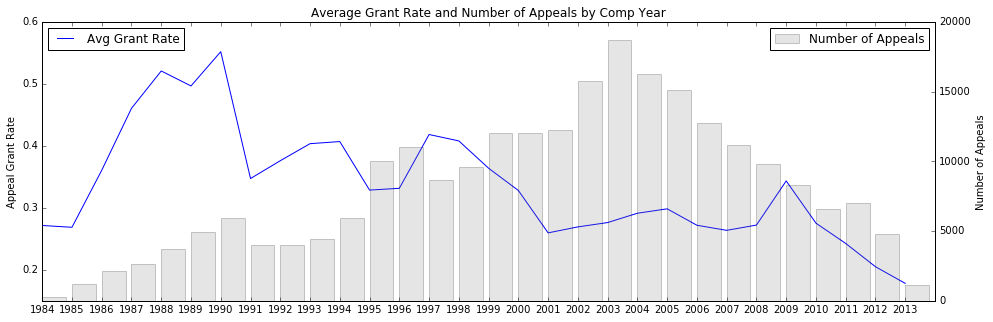

In [48]:
comp_year = plot_feature(appeals, ['comp_year'], 'Comp Year', limit_range=(1984, 2014)); 

In [49]:
# grant rate plunged in 2001; applications also dipped for first time in many years 
comp_year[(comp_year.index > 1997) & (comp_year.index < 2005)]

,size,mean
comp_year,,
1998,9596,0.407878
1999,12058,0.363825
2000,12011,0.327949
2001,12278,0.259570
2002,15725,0.269189
2003,18708,0.276192
2004,16286,0.291232


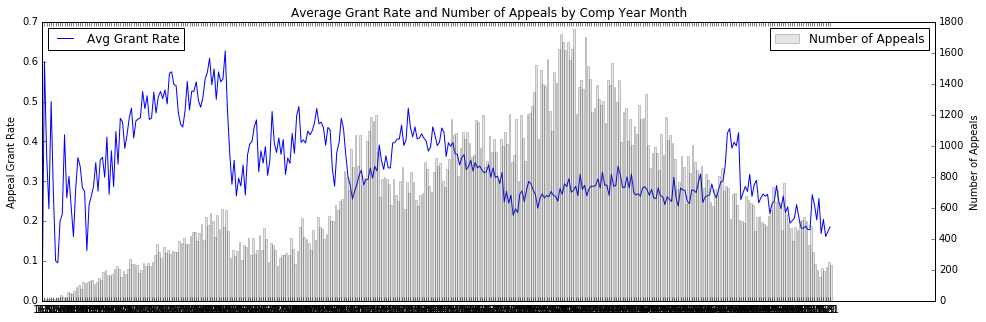

In [50]:
comp_year_month = plot_feature(appeals, ['comp_year_month'], 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

In [51]:
# narrowed down the dip to comp_year_month = 375 (March 2011)
comp_year_month[(comp_year_month.index >= (2001-1970)*12) & (comp_year_month.index < (2002-1970)*12)]

,size,mean
comp_year_month,,
372,780,0.312821
373,1043,0.294343
374,1000,0.322000
375,1089,0.247934
376,1012,0.274704
377,1208,0.245033
378,895,0.264804
379,938,0.214286
380,1170,0.230769


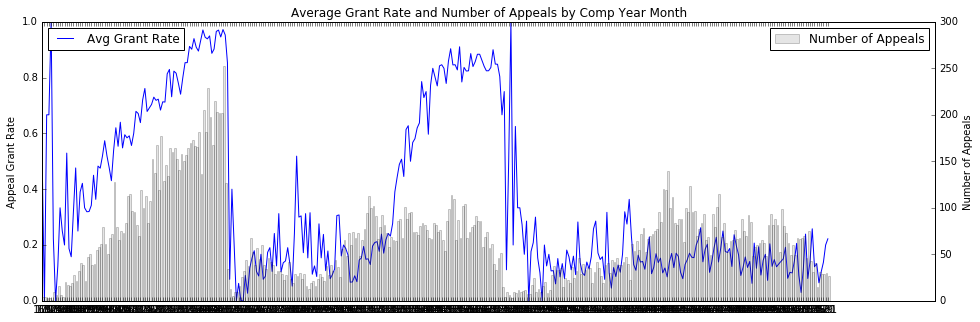

In [52]:
# appears to be due to El Salvador: plot of El Sav below 
comp_year_month_el_salv = plot_feature(appeals[appeals['nat_grouped'] == 'EL SALVADOR'], 
                                       'comp_year_month', 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

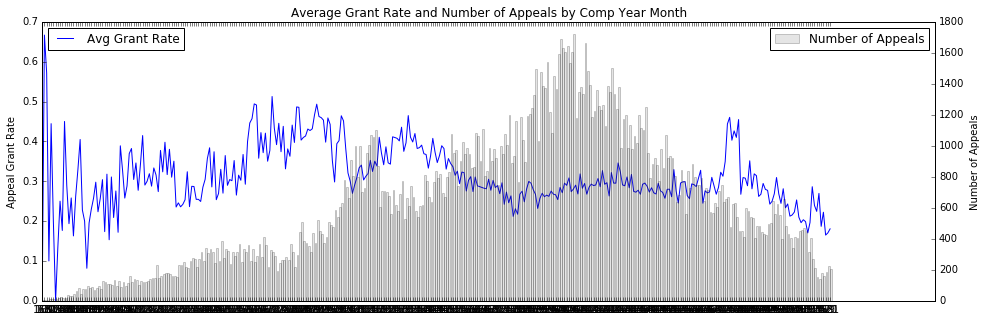

In [53]:
# appears to be due to El Salvador: plot without El Savl
comp_year_month_not_el_salv = plot_feature(appeals[appeals['nat_grouped'] != 'EL SALVADOR'], 
                                           'comp_year_month', 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

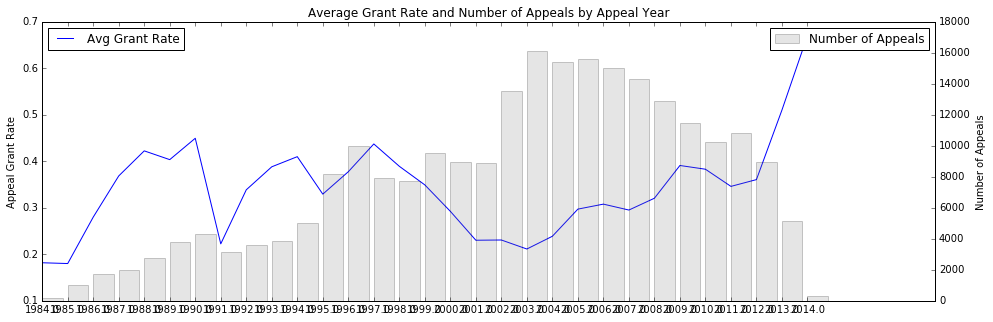

In [54]:
appeal_year = plot_feature(appeals, ['datAppealFiled_year'], 'Appeal Year', limit_range=(1984, 2014));

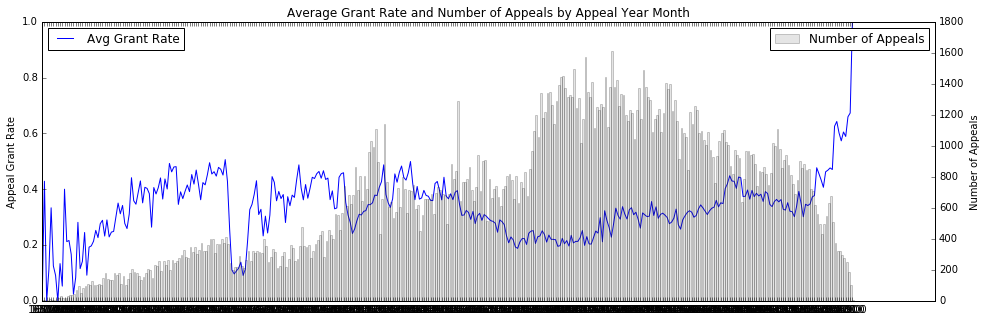

In [55]:
appeal_year_month = plot_feature(appeals, ['datAppealFiled_year_month'], 'Appeal Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

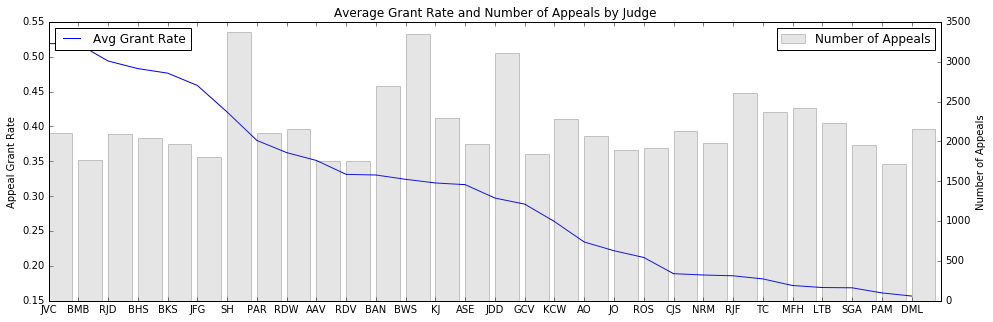

In [60]:
judge = plot_feature(appeals, ['ij_code_grouped'], 'Judge', limit_top_n=30, sort_by='mean-high-low'); 

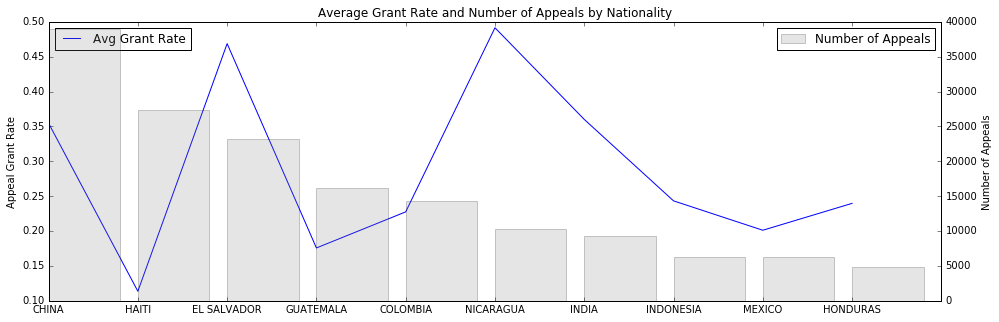

In [68]:
nat = plot_feature(appeals, ['nat_grouped'], 'Nationality', limit_top_n=10, sort_by='size'); 

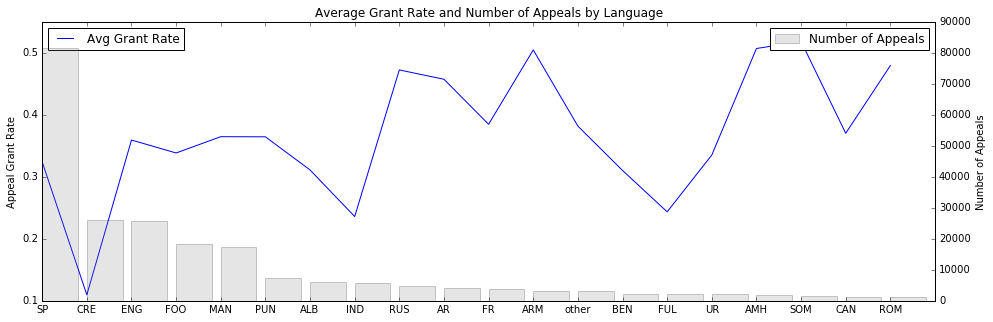

In [69]:
lang = plot_feature(appeals, ['lang_grouped'], 'Language', limit_top_n=20, sort_by='size');  

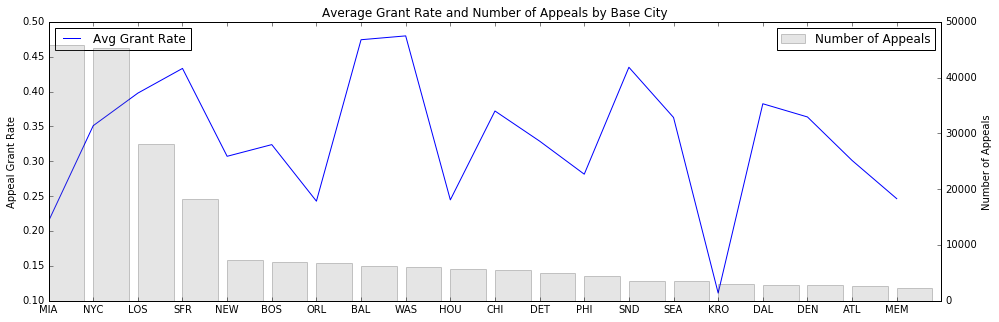

In [70]:
base_city = plot_feature(appeals, ['base_city_code'], 'Base City', limit_top_n=20, sort_by='size');  

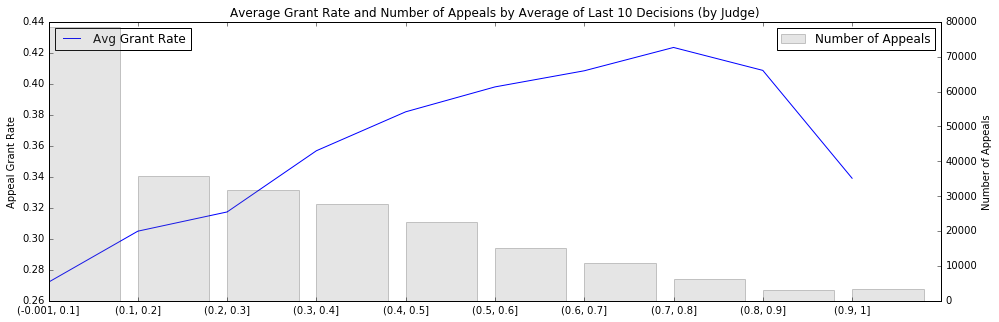

In [73]:
appeals['last_10_appeal_grant_by_judge_bin'] = pd.cut(appeals['last_10_appeal_grant_by_judge'], bins=10)
last_10_judge = plot_feature(appeals, ['last_10_appeal_grant_by_judge_bin'], 
                             'Average of Last 10 Decisions (by Judge)', sort_by='index');  

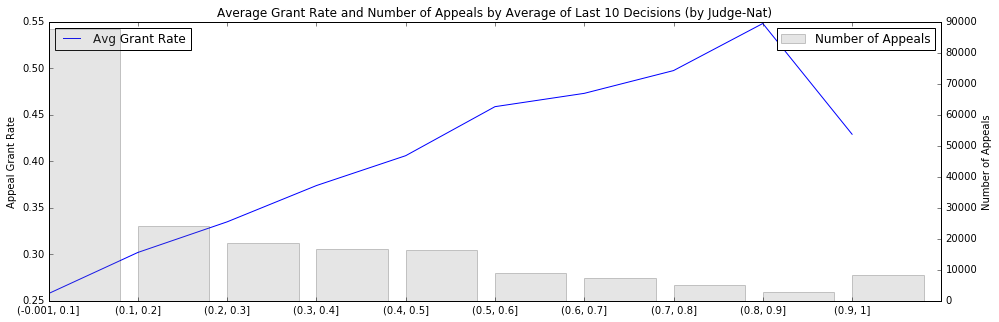

In [72]:
appeals['last_10_appeal_grant_by_judge_nat_bin'] = pd.cut(appeals['last_10_appeal_grant_by_judge_nat'], bins=10)
last_10_judge = plot_feature(appeals, ['last_10_appeal_grant_by_judge_nat_bin'], 
                             'Average of Last 10 Decisions (by Judge-Nat)', sort_by='index');  